# Preprocessing The Data

#### Finding Number of images in Each Set
Lets check how many images we have for each class in train and test sets.

#### Normalization

In order to speedup the training time we can devide the image matrices by 255 to map them to the range of [0,1].

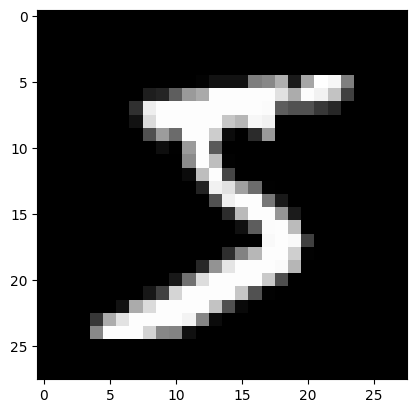

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# A function to plot images
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')


# Reading The Train Set
train_images_file = open('train-images.idx3-ubyte', 'rb')
train_images_file.seek(4)
num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
train_images_file.seek(16)

train_labels_file = open('train-labels.idx1-ubyte', 'rb')
train_labels_file.seek(8)

train_images, train_labels = [], []
for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    image = np.array(image).reshape((28, 28, 1))
    train_images.append(image)
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    train_labels.append(label)
    
    # train_set.append((aimage, label))


# Reading The Test Set
test_images_file = open('t10k-images.idx3-ubyte', 'rb')
test_images_file.seek(4)

test_labels_file = open('t10k-labels.idx1-ubyte', 'rb')
test_labels_file.seek(8)

num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
test_images_file.seek(16)

test_images, test_labels = [], []
for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
    image = np.array(image).reshape((28, 28, 1))
    test_images.append(image)
    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    test_labels.append(label)


# Plotting an image
show_image(train_images[0])
plt.show()

## Convert to numpy array
As we need numpy array to implement LeNet-5 using numpy, we need to transfer array lists to numpy array

In [21]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

## Shuffle the Image and Labels Matrices

We should write a shuffle function to perform it on the data because we need it later in backpropagation process.

In [22]:
from sklearn.utils import shuffle
import time

def shuffle_together(x, y):
  return shuffle(x, y, random_state=int(time.time()))

train_images, train_labels = shuffle_together(train_images, train_labels)
test_images, test_labels = shuffle_together(test_images, test_labels)
# train_images = train_images.reshape((train_images.shape[0], train_images.shape[1]))
# test_images = test_images.reshape((test_images.shape[0], test_images.shape[1]))
train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1]))
test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1]))

assert train_images.shape == (60000, 28, 28, 1)
assert train_labels.shape == (60000, 10)
assert test_images.shape == (10000, 28, 28, 1)
assert test_labels.shape == (10000, 10)

print("\033[92m All tests passed.")

 All tests passed.


# Implementing Convolutional Neural Network (CNN)
LeNet-5 Architecture
1. Input Layer
    * Input Size: 32 × 32 grayscale image (1 channel)
2. C1 - First Convolutional Layer
    * Number of Filters: 6
    * Filter Size: 5 × 5
    * Stride: 1
    * Padding: 2 (to maintain the input size as 32 × 32)
    * Output Size: 28 × 28 × 6 (28 x 28 spatial dimensions with 6 channels)
3. S2 - First Subsampling (Pooling) Layer
    * Type: Average Pooling
    * Filter Size: 2 × 2
    * Stride: 2
    * Output Size: 14 × 14 ×6
4. C3 - Second Convolutional Layer
    * Number of Filters: 16
    * Filter Size: 5 × 5
    * Stride: 1
    * Padding: 0
    * Output Size: 10 × 10 × 16
5. S4 - Second Subsampling (Pooling) Layer
    * Type: Average Pooling
    * Filter Size: 2 × 2
    * Stride: 2
    * Output Size: 5 × 5 × 16
6. C5 - Third Convolutional Layer
    * Number of Filters: 120
    * Filter Size: 5 × 5
    * Stride: 1
    * Padding: 0
    * Output Size: 1 × 1 × 120
7. F6 - Fully Connected Layer
    * Number of Neurons: 84
    * Activation: Tanh
8. Output Layer
    * Number of Neurons: 10 (for digit classification from 0 to 9)
    * Activation: Softmax

In [ ]:
class Conv():
    weight = None
    bias = None
    nc = None
    filter_size = None
    stride = None
    pad = None
    learn_rate = None
    img = None

    def __init__(self, nc = 0, filter_size = 0, stride = 1, pad = 0, learn_rate = 0.01):
        self.nc = nc
        self.filter_size = filter_size
        self.bias = np.random.randn(1, 1, 1, nc) * (1 / 1500)
        self.weight = np.random.randn(filter_size, filter_size, 1, nc) * (1 / 1500)
        self.stride = stride
        self.pad = pad
        self.learn_rate = learn_rate

    def forward_prop(self, img):

        if self.img is None:
            self.img = img
        
        (layer, nh_prev, nw_prev, nc_prev) = img.shape

        nh = int((nh_prev + 2 * self.pad - self.filter_size) / self.stride) + 1
        nw = int((nw_prev + 2 * self.pad - self.filter_size) / self.stride) + 1

        Z = np.zeros((layer, nh, nw, self.nc))

        for i in range(layer):
            current_img = img[i]
            for h in range(nh):
                vertical_start = self.stride * h
                vertical_end = vertical_start + self.filter_size
                for w in range(nw):
                    horizontal_start = self.stride * w
                    horizontal_end = horizontal_start + self.filter_size
                    for c in range(self.nc):
                        slice_of_img = current_img[vertical_start:vertical_end, horizontal_start:horizontal_end, :]
                        weights = self.weight[:, :, :,c]
                        biases = self.bias[:, :, :,c]
                        z = np.multiply(slice_of_img, weights)
                        biases = np.squeeze(biases)
                        z += biases
                        Z[i, h, w, c] = z
        return Z
    
    def back_prop (self, dZ):
        (layer, nh, nw, nc) = dZ.shape
        dimg = np.zeros(self.img.shape)
        dweight = np.zeros(self.weight.shape)
        dbias = np.zeros(self.bias.shape)

        img_pad = np.pad(self.img, ((0, 0), (self.pad, self.pad), (self.pad, self.pad), (0, 0)))
        dimg_pad = np.pad(dimg, ((0, 0), (self.pad, self.pad), (self.pad, self.pad), (0, 0)))
        for i in range(layer):
            current_img_pad = img_pad[i]
            current_dimg = dimg_pad[i]
            for h in range(nh):
                for w in range(nw):
                    for c in range(nc):
                        vertical_start = self.stride * h
                        horizontal_start = self.stride * w

                        slice_of_img = current_img_pad[vertical_start:vertical_start + self.filter_size, horizontal_start:horizontal_start + self.filter_size, :]
                                            # Update gradients for the window and the filter's parameters using the code formulas given above
                        current_dimg[vertical_start:vertical_start + self.filter_size, horizontal_start:horizontal_start + self.filter_size, :] += self.weight[:,:,:,c] * dZ[i, h, w, c]
                        dweight[:,:,:,c] += slice_of_img * dZ[i, h, w, c]
                        dbias[:,:,:,c] += dZ[i, h, w, c]
            dimg[i, :, :, :] = dimg_pad[self.pad:-self.pad, self.pad:-self.pad, :]
        # assert(dimg.shape == (layer, n_H_prev, n_W_prev, self.nc))

        return dimg, dweight, dbias